In [1]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from util import deep_update_dict
from env import ActionOffsetLunarLander, collect_trajectories
from algorithms import NoOffsetDDPG, NaiveDDPG, OffsetMLPDDPG, PearlDDPG, SimplifiedPearlDDPG

In [3]:
with open("manually_saved_runs/no_offset_ddpg_4/config.json") as fp:
    config = json.load(fp)
no_offset = NoOffsetDDPG(config, load_dir="manually_saved_runs/no_offset_ddpg_4")

with open("manually_saved_runs/naive_ddpg_4/config.json") as fp:
    config = json.load(fp)
naive = NaiveDDPG(config, load_dir="manually_saved_runs/naive_ddpg_4")

with open("manually_saved_runs/no_offset_ddpg_4/config.json") as fp:
    config = json.load(fp)
offset_mlp = OffsetMLPDDPG(config, load_dir="manually_saved_runs/no_offset_ddpg_4",
                            offset_net_path="notebooks/output/sas_to_offset_MLP_4_with_1_offset_bestval.pt", prior=False)

with open("manually_saved_runs/no_offset_ddpg_4/config.json") as fp:
    config = json.load(fp)
offset_mlp_naive = OffsetMLPDDPG(config, load_dir="manually_saved_runs/naive_ddpg_4",
                            offset_net_path="notebooks/output/sas_to_offset_MLP_4_with_1_offset_bestval.pt", prior=False)

with open("manually_saved_runs/no_offset_ddpg_4/config.json") as fp:
    config = json.load(fp)
offset_mlp_prior = OffsetMLPDDPG(config, load_dir="manually_saved_runs/no_offset_ddpg_4",
                            offset_net_path="notebooks/output/sas_to_offset_MLP_4_with_1_offset_bestval.pt", prior=True)

with open("manually_saved_runs/no_offset_ddpg_4/config.json") as fp:
    config = json.load(fp)
offset_mlp_prior_naive = OffsetMLPDDPG(config, load_dir="manually_saved_runs/naive_ddpg_4",
                            offset_net_path="notebooks/output/sas_to_offset_MLP_4_with_1_offset_bestval.pt", prior=True)

with open("manually_saved_runs/simplified_pearl_ddpg_3/config.json") as fp:
    config = json.load(fp)
simplified_pearl = SimplifiedPearlDDPG(config, load_dir="manually_saved_runs/simplified_pearl_ddpg_3")

with open("config/pearl_ddpg.json") as fp:
    temp_config = json.load(fp)
with open("manually_saved_runs/pearl_ddpg_3/config.json") as fp:
    config = json.load(fp)
config = deep_update_dict(config, temp_config)
pearl = PearlDDPG(config, load_dir="manually_saved_runs/pearl_ddpg_3")

In [4]:
min_engine_power = 0
env = ActionOffsetLunarLander(min_engine_power)

In [18]:
max_action_offset = 1.0
num_tasks = 11
num_episodes = 10

def task_returns_and_lengths(trainer, action_dim):
    task_params = np.zeros((num_tasks, 2))
    task_params[:, action_dim] = np.linspace(-max_action_offset, max_action_offset, num_tasks)
    
    task_trajs, _, _ = collect_trajectories(env, trainer.current_policy(), task_params, num_episodes, eval=True)
    
    return {
        "returns": [np.mean([sum(traj.rewards) for traj in trajs]) for trajs in task_trajs],
        "lengths": [np.mean([len(traj) for traj in trajs]) for trajs in task_trajs]
    }

def task_returns_2d(trainer):
    x, y = np.mgrid[-max_action_offset:max_action_offset:num_tasks*1j,
                    -max_action_offset:max_action_offset:num_tasks*1j]
    task_params = np.vstack((x.flatten(), y.flatten())).T
    
    task_trajs, _, _ = collect_trajectories(env, trainer.current_policy(), task_params, num_episodes, eval=True)
    
    rewards = [
        np.mean([sum(traj.rewards) for traj in trajs])
        for trajs in task_trajs
    ]
    rewards = np.asarray(rewards).reshape((num_tasks,num_tasks))
    
    return rewards

### Get data for line plots

In [19]:
returns_and_lengths = {}

In [20]:
returns_and_lengths.update({
    "No Offset": [
        task_returns_and_lengths(no_offset, 0),
        task_returns_and_lengths(no_offset, 1)
    ],
    "Naive": [
        task_returns_and_lengths(naive, 0),
        task_returns_and_lengths(naive, 1)
    ],
    "Offset Correction MLP": [
        task_returns_and_lengths(offset_mlp, 0),
        task_returns_and_lengths(offset_mlp, 1)
    ],
    "Offset Correction MLP (Prior)": [
        task_returns_and_lengths(offset_mlp_prior, 0),
        task_returns_and_lengths(offset_mlp_prior, 1)
    ],
    # "Offset Correction MLP (Naive)": [
    #     task_returns_and_lengths(offset_mlp_naive, 0),
    #     task_returns_and_lengths(offset_mlp_naive, 1)
    # ],
    # "Offset Correction MLP (Prior)(Naive)": [
    #     task_returns_and_lengths(offset_mlp_prior_naive, 0),
    #     task_returns_and_lengths(offset_mlp_prior_naive, 1)
    # ],
    # "Simplified PEARL": [
    #     task_returns_and_lengths(simplified_pearl, 0),
    #     task_returns_and_lengths(simplified_pearl, 1)
    # ],
    # "PEARL": [
    #     task_returns_and_lengths(pearl, 0),
    #     task_returns_and_lengths(pearl, 1)
    # ],
})

### Plot episode lengths

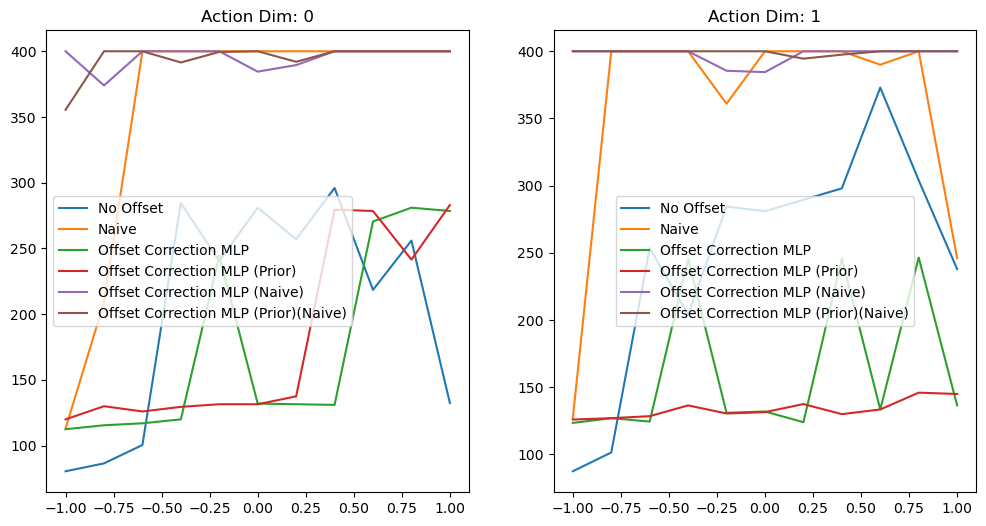

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
x = np.linspace(-max_action_offset, max_action_offset, num_tasks)
for i in range(2):
    for key in returns_and_lengths.keys():
        axs[i].plot(x, returns_and_lengths[key][i]["lengths"], label=key)
    axs[i].set_title(f"Action Dim: {i}")
    axs[i].legend()

### Plot Performance Profiles

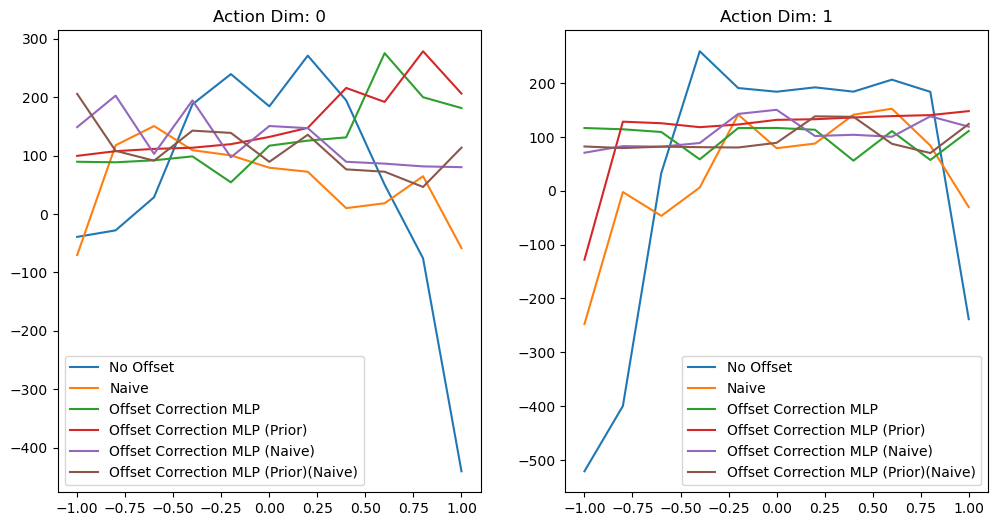

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
x = np.linspace(-max_action_offset, max_action_offset, num_tasks)
for i in range(2):
    for key in returns_and_lengths.keys():
        axs[i].plot(x, returns_and_lengths[key][i]["returns"], label=key)
    axs[i].set_title(f"Action Dim: {i}")
    axs[i].legend()

### Pretty plots

In [23]:
old_to_new_labels = {
    "No Offset": "DDPG trained without offsets",
    "Naive": "DDPG trained with offsets",
    "Offset Correction MLP": "Explicit offset estimation",
    "Offset Correction MLP (Prior)": "Explicit offset estimation (Prior)",
    # "Offset Correction MLP (Naive)": "Explicit offset estimation (Naive)",
    # "Offset Correction MLP (Prior)(Naive)": "Explicit offset estimation (Prior)(Naive)",
    # "Simplified PEARL": "End-to-end explicit offset estimation",
    # "PEARL": "PEARL",
}
returns_and_lengths_pretty = {new_label: returns_and_lengths[old_label] for old_label,new_label in old_to_new_labels.items()}

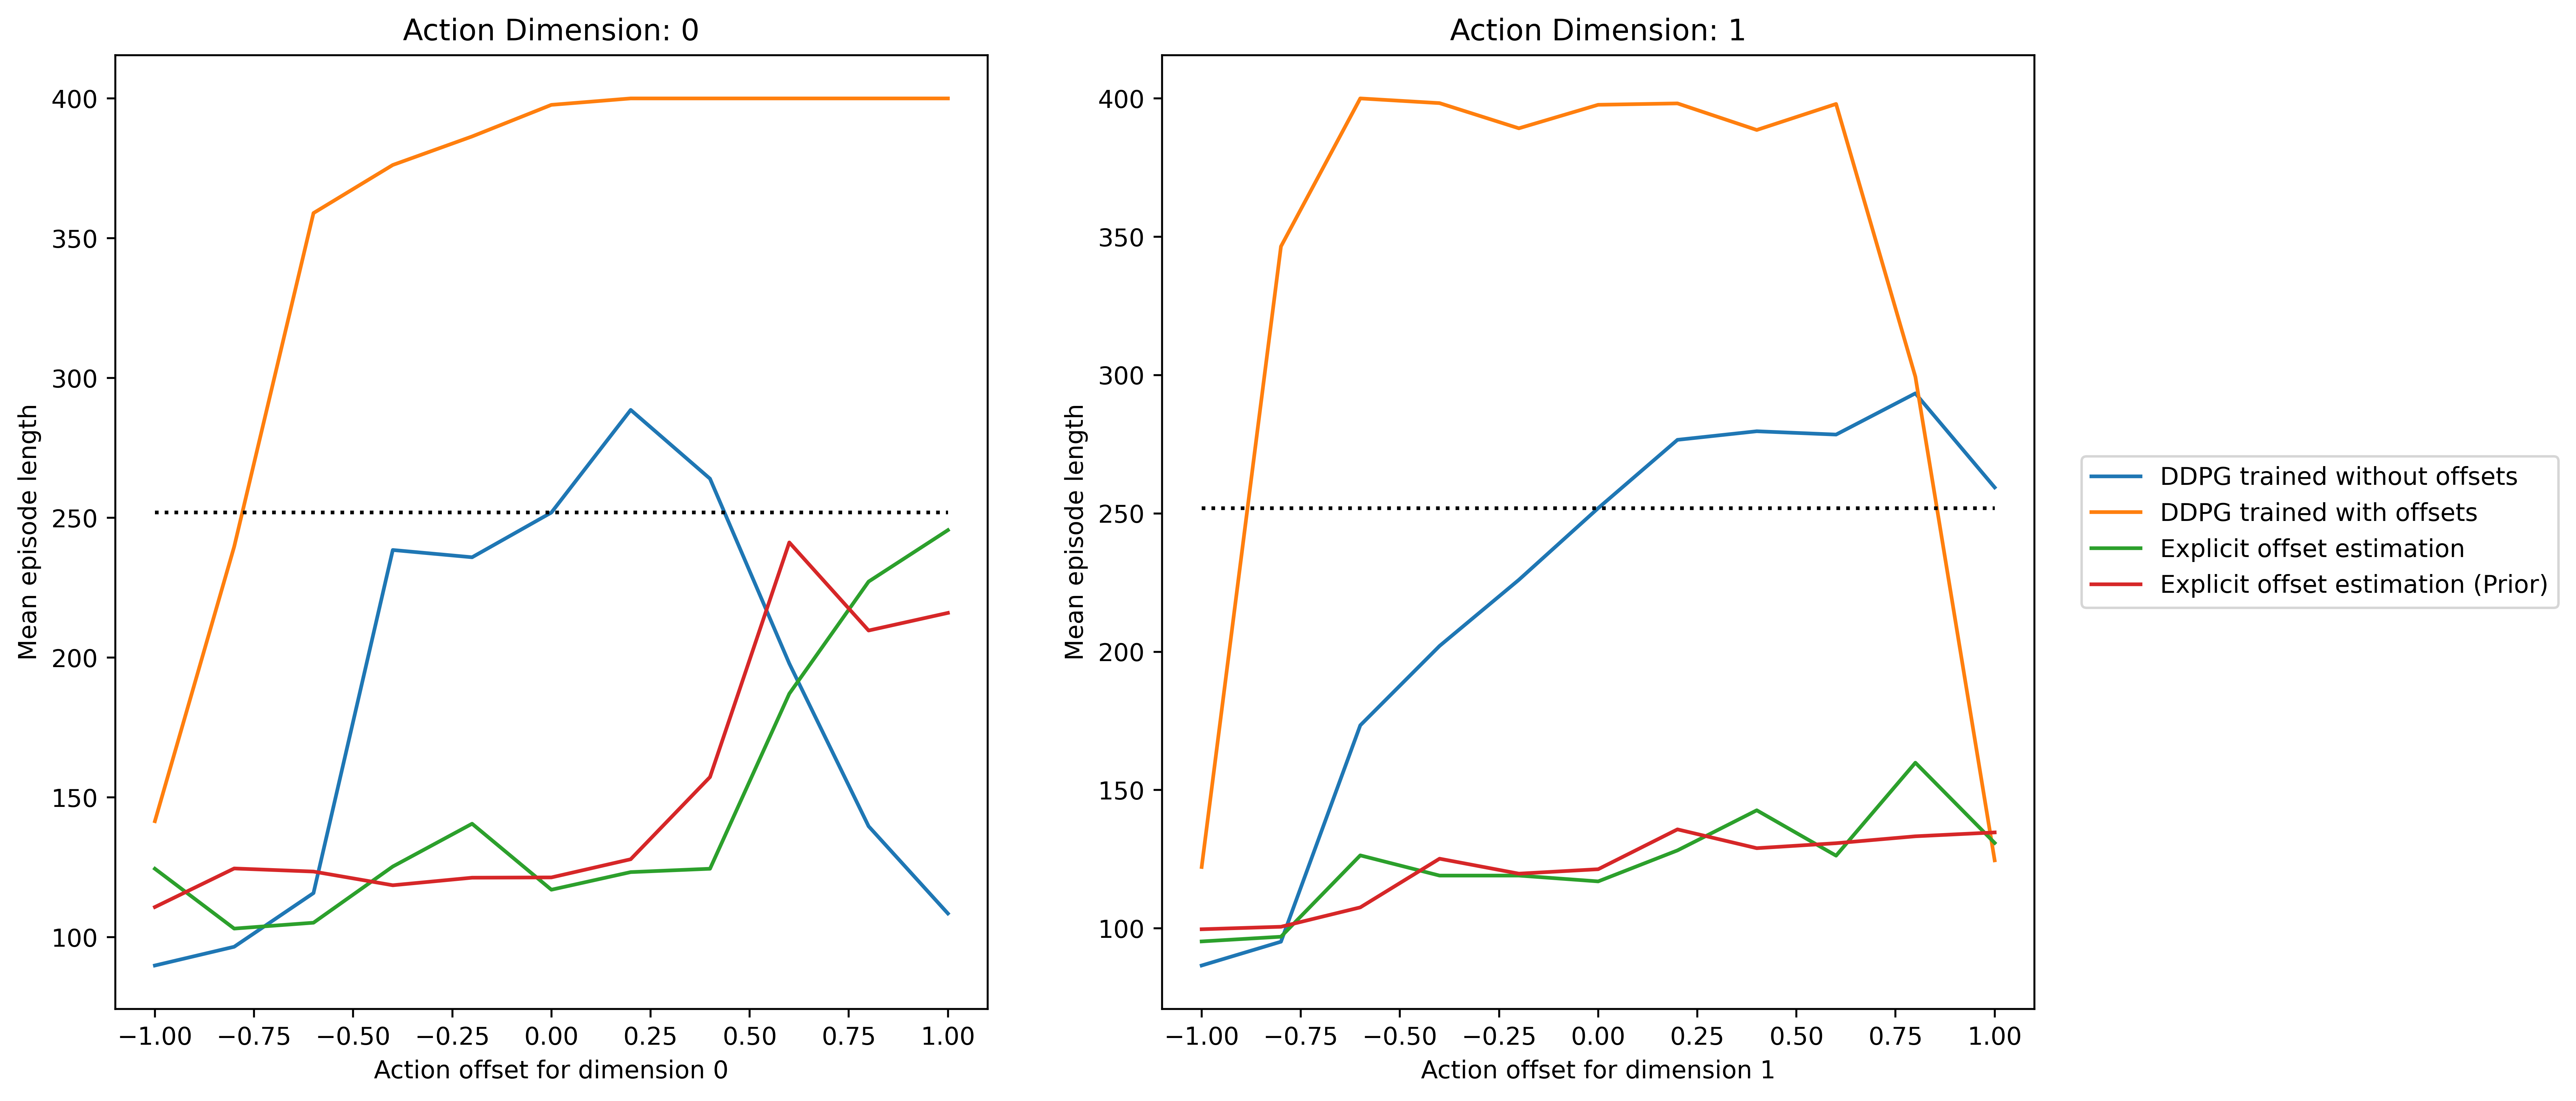

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), dpi=500)
x = np.linspace(-max_action_offset, max_action_offset, num_tasks)
for i in range(2):
    for key in returns_and_lengths_pretty.keys():
        axs[i].plot(x, returns_and_lengths_pretty[key][i]["lengths"], label=key)
    axs[i].plot(x, [returns_and_lengths_pretty["DDPG trained without offsets"][i]["lengths"][num_tasks//2]]*num_tasks, color='black', linestyle='dotted')
    axs[i].set_title(f"Action Dimension: {i}")
    axs[i].set_ylabel("Mean episode length")
    axs[i].set_xlabel(f"Action offset for dimension {i}")

axs[1].legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
None

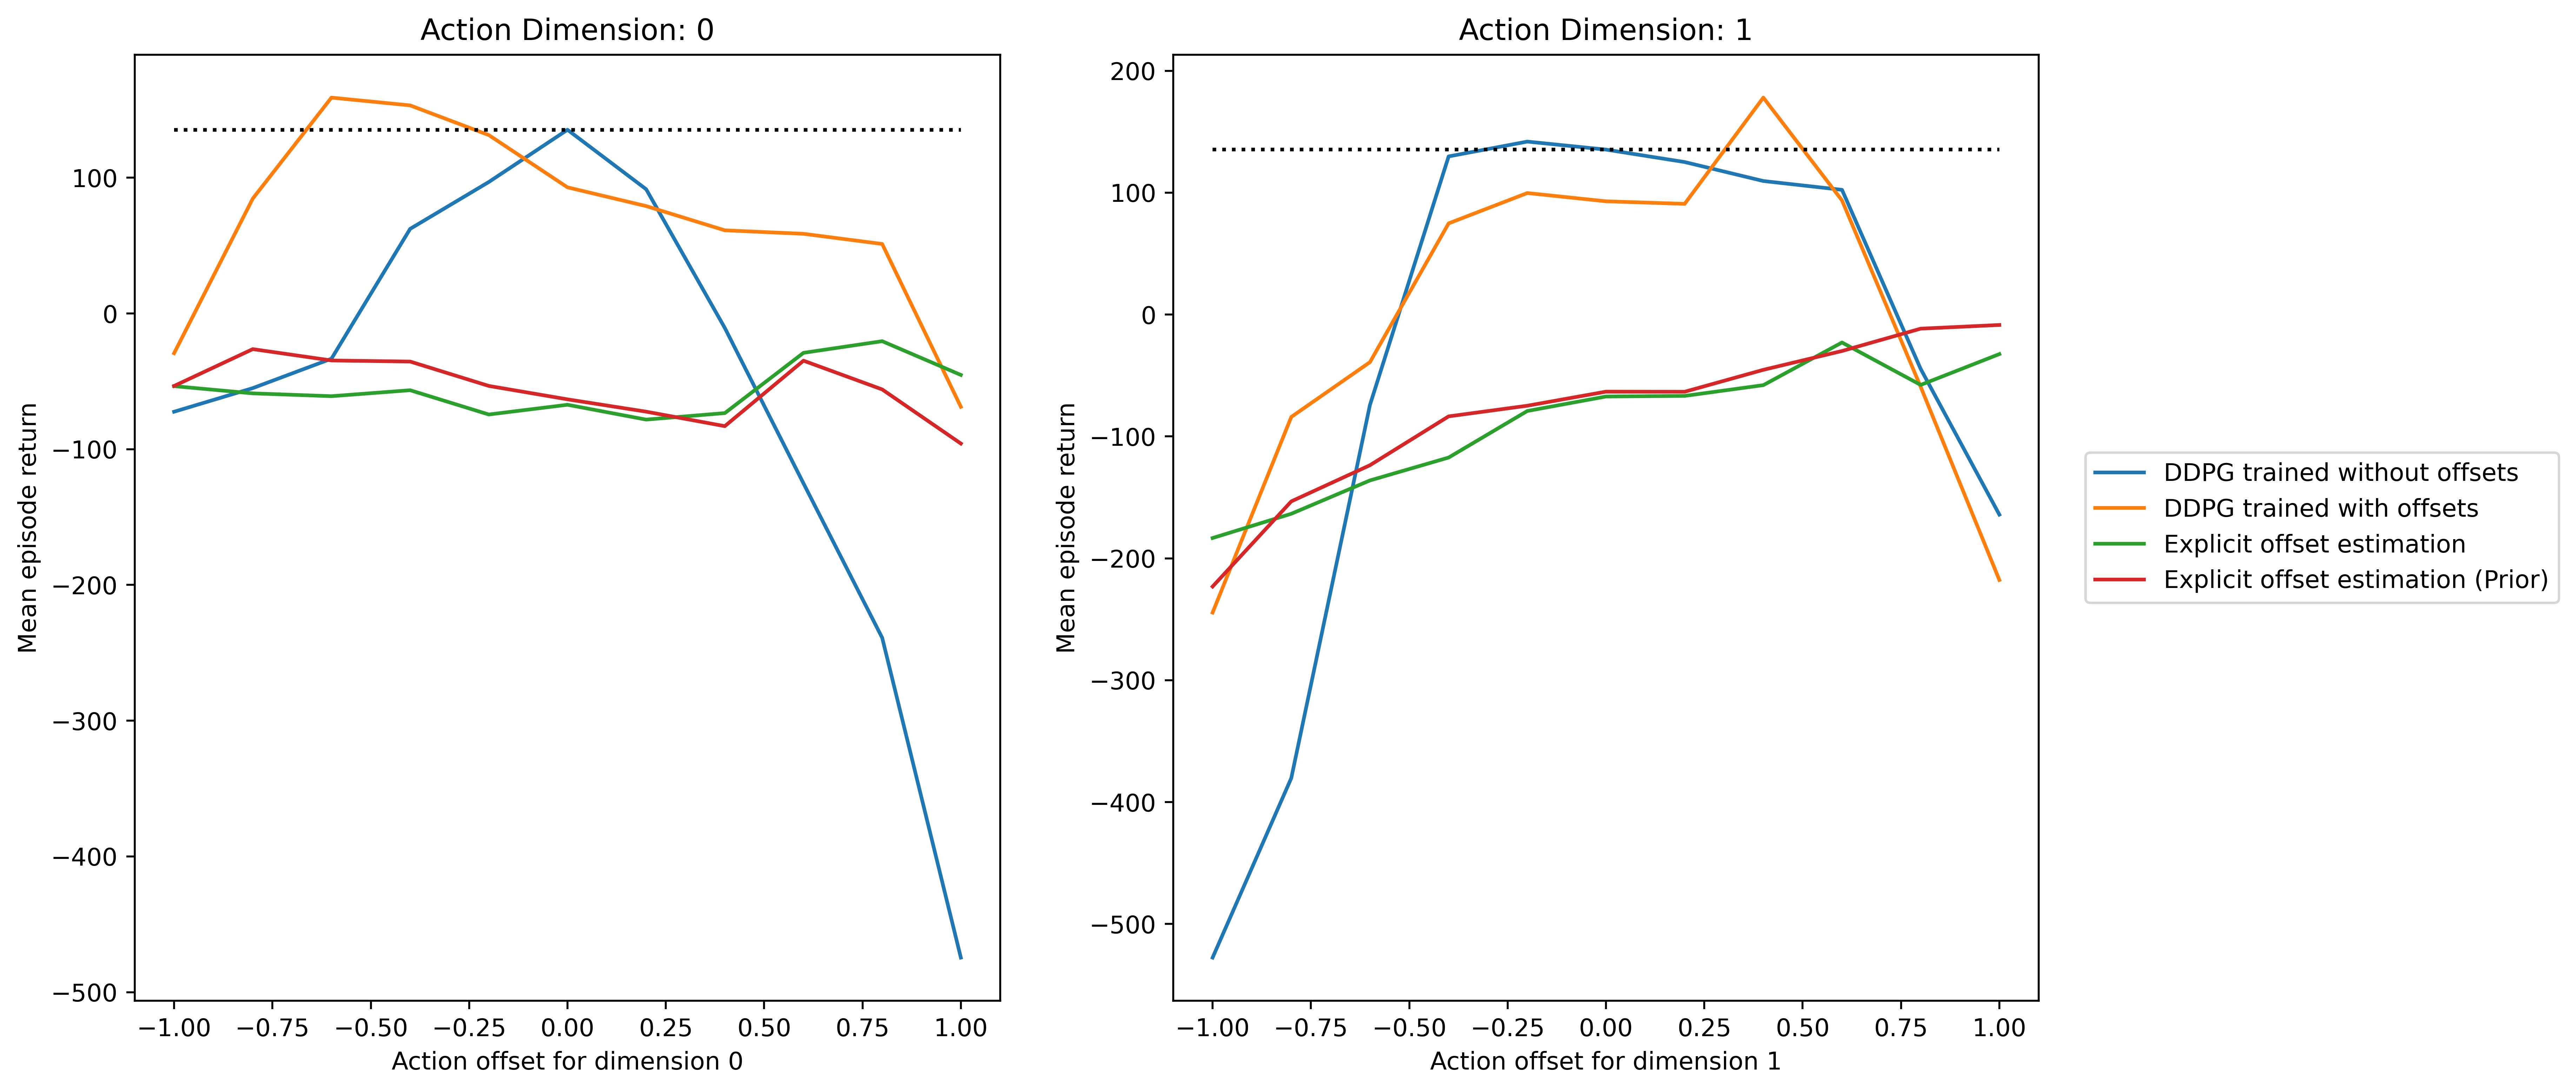

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), dpi=500)
x = np.linspace(-max_action_offset, max_action_offset, num_tasks)
for i in range(2):
    for key in returns_and_lengths_pretty.keys():
        axs[i].plot(x, returns_and_lengths_pretty[key][i]["returns"], label=key)
    axs[i].plot(x, [returns_and_lengths_pretty["DDPG trained without offsets"][i]["returns"][num_tasks//2]]*num_tasks, color='black', linestyle='dotted')
    axs[i].set_title(f"Action Dimension: {i}")
    axs[i].set_ylabel("Mean episode return")
    axs[i].set_xlabel(f"Action offset for dimension {i}")

axs[1].legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
None

#### Heatmaps for 2D evaluation

In [11]:
returns_2d = {
    "No Offset": task_returns_2d(no_offset),
    "Naive": task_returns_2d(naive),
    "Offset Correction MLP, 0.5 offset": task_returns_2d(offset_mlp_05_offset),
    "Offset Correction MLP, 1.0 offset": task_returns_2d(offset_mlp_1_offset),
}

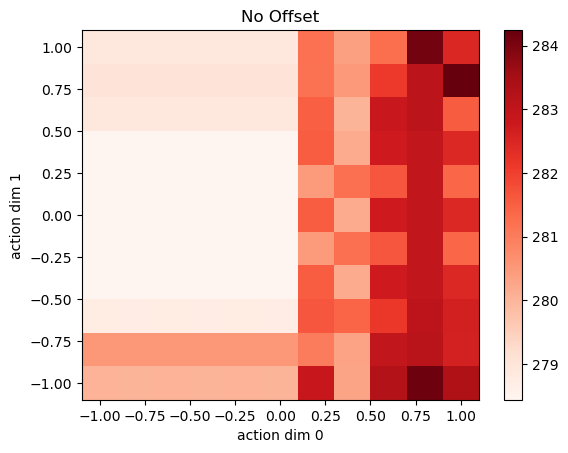

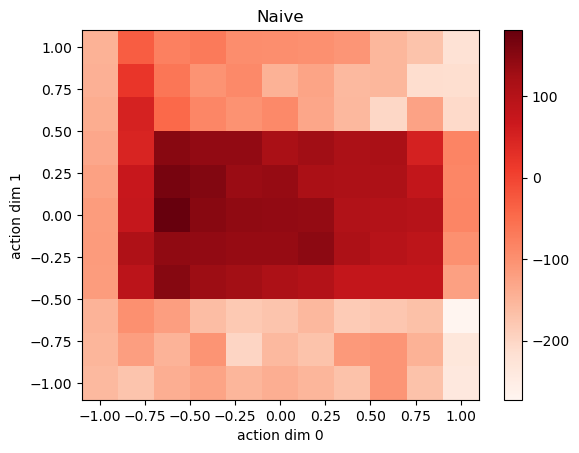

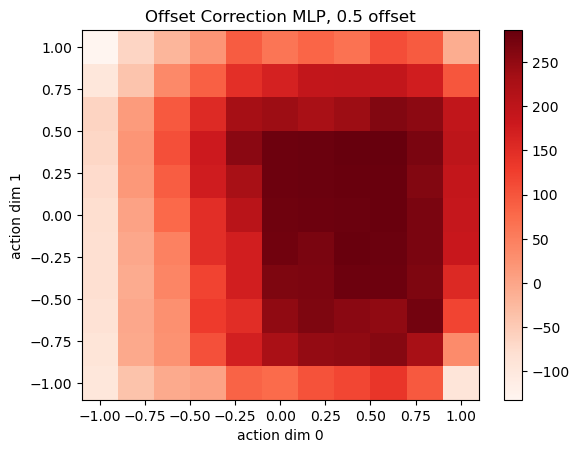

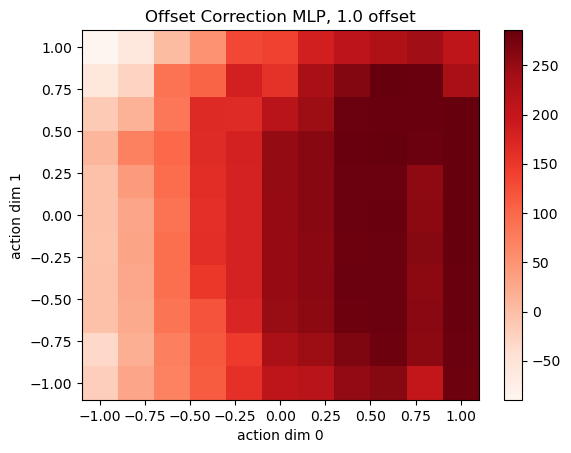

In [12]:
use_global_cbars = True
global_z_min = 

for name, z in returns_2d.items():
    max_offset_for_grid = max_action_offset + (max_action_offset/(num_tasks-1))

    x, y = np.mgrid[-max_offset_for_grid:max_offset_for_grid:(num_tasks+1)*1j,
                    -max_offset_for_grid:max_offset_for_grid:(num_tasks+1)*1j]

    z_min, z_max = z.min(), z.max()

    fig, ax = plt.subplots()

    c = ax.pcolormesh(x, y, z, cmap='Reds', vmin=z_min, vmax=z_max)
    ax.set_title(name)
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)

    ax.set_xlabel('action dim 0')
    ax.set_ylabel('action dim 1')

    plt.show()

### Save Replays at Max Offsets

In [10]:
from gymnasium.utils.save_video import save_video
def save_boundary_replays(trainer):
    task_params = np.zeros((4, 2))
    task_params[0, 0] = max_action_offset
    task_params[1, 0] = -max_action_offset
    task_params[2, 1] = max_action_offset
    task_params[3, 1] = -max_action_offset

    _, _, frames = collect_trajectories(env, trainer.current_policy(), task_params, 4, render=True)
    for i in range(len(task_params)):
        save_video(
            frames[i],
            "temp",
            episode_trigger=lambda x: True,
            fps=env.metadata["render_fps"],
            name_prefix=f"{trainer.__class__.__name__}.offset_{task_params[i, 0]:.2f}_{task_params[i, 1]:.2f}"
        )

In [11]:
save_boundary_replays(no_offset)
save_boundary_replays(naive)

Moviepy - Building video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_1.00_0.00-episode-0.mp4.
Moviepy - Writing video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_1.00_0.00-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_1.00_0.00-episode-0.mp4
Moviepy - Building video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_-1.00_0.00-episode-0.mp4.
Moviepy - Writing video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_-1.00_0.00-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_-1.00_0.00-episode-0.mp4
Moviepy - Building video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_0.00_1.00-episode-0.mp4.
Moviepy - Writing video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_0.00_1.00-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_0.00_1.00-episode-0.mp4
Moviepy - Building video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_0.00_-1.00-episode-0.mp4.
Moviepy - Writing video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_0.00_-1.00-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NoOffsetDDPG.offset_0.00_-1.00-episode-0.mp4
Moviepy - Building video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_1.00_0.00-episode-0.mp4.
Moviepy - Writing video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_1.00_0.00-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_1.00_0.00-episode-0.mp4
Moviepy - Building video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_-1.00_0.00-episode-0.mp4.
Moviepy - Writing video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_-1.00_0.00-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_-1.00_0.00-episode-0.mp4
Moviepy - Building video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_0.00_1.00-episode-0.mp4.
Moviepy - Writing video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_0.00_1.00-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_0.00_1.00-episode-0.mp4
Moviepy - Building video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_0.00_-1.00-episode-0.mp4.
Moviepy - Writing video d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_0.00_-1.00-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\OneDrive\code\Stanford\CS-238\Final Project\temp/NaiveDDPG.offset_0.00_-1.00-episode-0.mp4
